<a href="https://colab.research.google.com/github/sjsyz/medium-assets/blob/main/syzz_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **syzz-1**
> This notebook is a supplement to my Medium post "Investigate BigQuery slowness with Python and INFORMATION_SCHEMA"

Slot resource contention is one of the most common reasons for slower BigQuery jobs. When the demand for slots is too high, jobs compete for resources and will not perform optimally. Use this notebook to deep dive into slot usage and trends in your environment. At a minimum, you must have already identified:


1.   A problematic job id
2.   The [reservation admin project](https://cloud.google.com/bigquery/docs/reservations-workload-management#admin-project) id
3.   The project's region


If you do not know this information, please contact your BigQuery administrator before running this notebook.




# **Authentication & Setup**
In this section, you grant this notebook access to your GCP environment and import several useful Python libraries for data analysis.

In [ ]:
# you will be redirected to a separate authentication page
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

In [ ]:
# enable data table display, which displays large pandas dataframes as an interactive data table
%load_ext google.colab.data_table

In [ ]:
# import libraries
from google.cloud import bigquery
import numpy as np
from scipy import stats
from datetime import datetime, date, timezone, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import re

# **Step 1: Gathering basic slowness information**  

#### _Figure 1. Summary of Job Information Example_

In [ ]:
# initialize variables
problematic_job_id = <JOB-ID>
admin_project_id = <PROJECT-ID>
client = bigquery.Client(project=admin_project_id)

In [ ]:
# query organization system tables
job_execution_sql = f'''
 SELECT
   project_id,
   job_id,
   reservation_id,
   EXTRACT(DATE FROM creation_time) AS creation_date,
   creation_time,
   end_time,
   TIMESTAMP_DIFF(end_time, start_time, SECOND) AS job_duration_seconds,
   job_type,
   user_email,
   state,
   error_result,
   total_bytes_processed,
   -- Average slot utilization per job is calculated by dividing
   -- total_slot_ms by the millisecond duration of the job
   SAFE_DIVIDE(total_slot_ms, (TIMESTAMP_DIFF(end_time, start_time, MILLISECOND))) AS avg_slots
 FROM
   `region-US`.INFORMATION_SCHEMA.JOBS_BY_ORGANIZATION
 ORDER BY
   creation_time DESC
'''

# save results as a dataframe
jobs_by_org = client.query(job_execution_sql).to_dataframe()
# display summary of job information
jobs_by_org.loc[jobs_by_org['job_id'] == problematic_job_id]

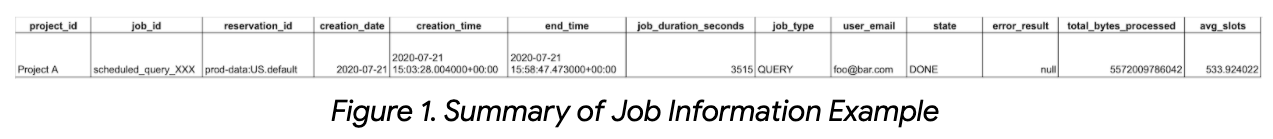

# **Step 2: Verifying whether the job is performing out of normal bounds**  

#### _Figure 2. Histogram Example_

In [ ]:
# initialize variable
problematic_job_project = <PROJECT-ID>
# initialize bigquery client for the other project
specific_client = bigquery.Client(project=problematic_job_project)

In [ ]:
# query project system tables
job_proj_specific_sql = f'''
 SELECT
   project_id,
   job_id,
   query,
   TIMESTAMP_DIFF(end_time, start_time, SECOND) AS job_duration_seconds
 FROM
   `region-US`.INFORMATION_SCHEMA.JOBS_BY_PROJECT
'''

# filter for the problematic job
specific_jobs = specific_client.query(job_proj_specific_sql).to_dataframe()
problematic_job = specific_jobs.loc[specific_jobs['job_id'] == problematic_job_id]

# search for similar jobs in the same project by query text
problematic_query_sample = problematic_job.iloc[0]['query']
similar_jobs = specific_jobs[specific_jobs['query'].str.contains(problematic_query_sample, na=False, regex=False)]
similar_jobs = similar_jobs[similar_jobs.job_id != problematic_job_id]

# plot histogram
similar_hist = similar_jobs.hist(column='job_duration_seconds')

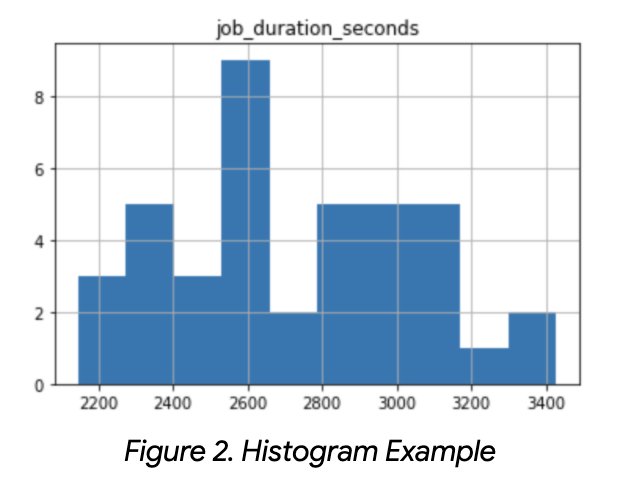

# **Step 3: Checking for slot resource contention**  

#### _Figure 3. Bar Chart Example_

In [ ]:
# store the problematic job’s information
job_info = jobs_by_org.loc[jobs_by_org['job_id'] == problematic_job_id]
ji_create_time = job_info.iloc[0]['creation_time']
ji_end_time = job_info.iloc[0]['end_time']
ji_reservation_id = job_info.iloc[0]['reservation_id']

# filter by job type and time
min_info = jobs_by_org.loc[(jobs_by_org['job_type'] == 'QUERY') & (jobs_by_org['creation_time'] >= ji_create_time) & (jobs_by_org['end_time'] <= ji_end_time) & (jobs_by_org['reservation_id'] == ji_reservation_id)]

# group by time and project, aggregate by job count
min_info['minutes_from_timestamps'] = min_info['creation_time'].dt.minute
grouped = min_info.groupby(['minutes_from_timestamps','project_id']).agg({'job_id': 'nunique'})
grouped.columns = ['job_count']
grouped = grouped.reset_index()

# plot bar chart
pvt = grouped.pivot(index="minutes_from_timestamps", columns="project_id", values="job_count")
pvt.plot(kind="bar", stacked="True", figsize=(20,10), title="Concurrent Jobs Over Time")

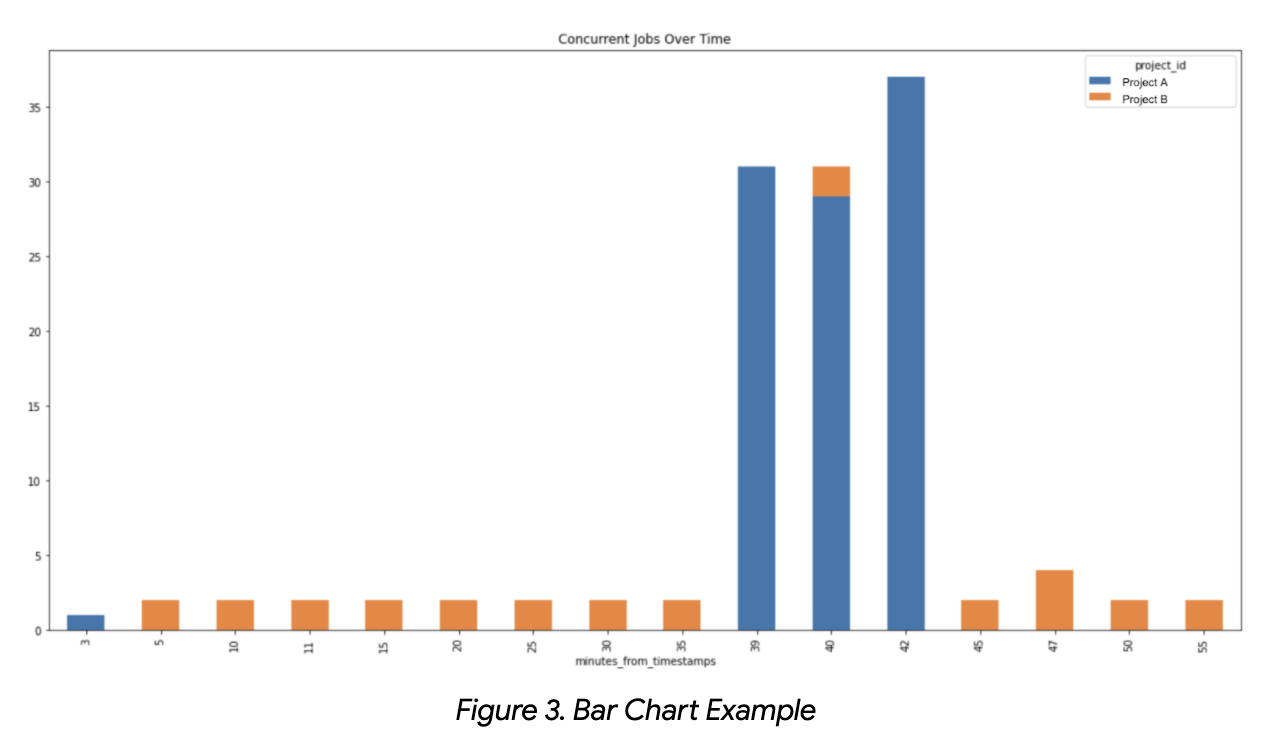